# Hands on Macine Learning Chapter 3 

## Exercises

## 1 

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [ ]:
#Fetches MNIST Dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [ ]:
# MNIST dataset is already split into a training set
#(the first 60,000 images) and a test set (the last 10,000 images):
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

In [ ]:
knn_clf.get_params()

In [ ]:
from sklearn.model_selection import GridSearchCV

#This way is incorrect
param_grid = [
              {'algorithm': ['ball_tree', 'kd_tree', 'brute'],
'leaf_size': [10,20,30,40],
 'metric': ['minkowski'],
 #'metric_params': None,
 #'n_jobs': None,
 'n_neighbors': [10], # I did 10 so that there would be one neighbor for each digit. 
 'p': [1,2,3],
 'weights': ['uniform', 'distance']}
  ]

#This is the solution they have in the book
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}] #There's is much more simple 
#But still take forever to run

grid_search = GridSearchCV(knn_clf, param_grid, cv=5,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)

In [ ]:
#Now it picks the optimal hyperparameters 
#Don't do this, it will take almost 10 hours
#grid_search.fit(X_train, y_train)


In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:

from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)


# 2.

Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.5 Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

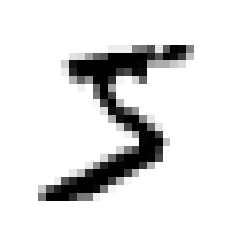

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [15]:
import scipy 
help(scipy.ndimage.interpolation)

Help on module scipy.ndimage.interpolation in scipy.ndimage:

NAME
    scipy.ndimage.interpolation

DESCRIPTION
    # Copyright (C) 2003-2005 Peter J. Verveer
    #
    # Redistribution and use in source and binary forms, with or without
    # modification, are permitted provided that the following conditions
    # are met:
    #
    # 1. Redistributions of source code must retain the above copyright
    #    notice, this list of conditions and the following disclaimer.
    #
    # 2. Redistributions in binary form must reproduce the above
    #    copyright notice, this list of conditions and the following
    #    disclaimer in the documentation and/or other materials provided
    #    with the distribution.
    #
    # 3. The name of the author may not be used to endorse or promote
    #    products derived from this software without specific prior
    #    written permission.
    #
    # THIS SOFTWARE IS PROVIDED BY THE AUTHOR ``AS IS'' AND ANY EXPRESS
    # OR IMPLIED WARRANTIES, 

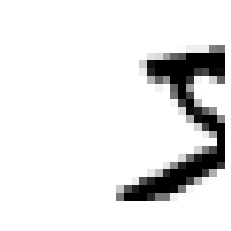

In [65]:
image = scipy.ndimage.interpolation.shift(X[0].reshape(28, 28), [0, 10], cval=0)
plt.imshow(image, cmap="binary")
plt.axis("off")
plt.show()

In [380]:
#takes the non reshaped arry 
def move_image_down(image):
    import numpy as np
    image = image.reshape(28,28)
    image = scipy.ndimage.interpolation.shift(image.reshape(28, 28), [1, 0], cval=0)
    return np.rint(image.reshape(784))

def move_image_up(image):
    import numpy as np
    image = image.reshape(28,28)
    image = scipy.ndimage.interpolation.shift(image.reshape(28, 28), [-1, 0], cval=0)
    return np.rint(image.reshape(784))

def move_image_left(image):
    import numpy as np
    image = image.reshape(28,28)
    image = scipy.ndimage.interpolation.shift(image.reshape(28, 28), [0, -1], cval=0)
    return np.rint(image.reshape(784))

def move_image_right(image):
    import numpy as np
    image = image.reshape(28,28)
    image = scipy.ndimage.interpolation.shift(image.reshape(28, 28), [0, 1], cval=0)
    return np.rint(image.reshape(784))

def move_image(image, where):
    if where.lower() == 'up':
        return np.array(move_image_up(image))
    if where.lower() == 'down':
        return np.array(move_image_down(image))
    if where.lower() == 'left':
        return np.array(move_image_left(image))
    if where.lower() == 'right':
        return np.array( move_image_right(image))

In [222]:
#Takes the non shaped image
def showImage(image):
    image = image.reshape(28,28)
    plt.imshow(image, cmap="binary")
    #Thats a lot of messed up pixels 
    plt.axis("off")
    plt.show()

# Try it with an array conversion 

In [429]:
#For some reason, the values are coming back as all zero
def enhance(data, labels):
    import numpy as np
    where = ['up', 'down', 'left', 'right']
    newLabels =  []#Labels is a list
    #new training should be an array and we append to that array. Do not work with a list 
    masterTraining = []
    for direction in where:
        #New Problem, everything is being saved to one array.
        #When index it equal to 0, we need to make a new array and save the prior array to an array
        for index, x in enumerate(data):
            masterTraining.append( move_image(x,direction))
            newLabels.append( labels[index] )
    return np.array(masterTraining), newLabels

In [430]:
newTraining, newLabels =  enhance(X, y)

In [437]:
#We determine the images by row so we need to vstack
X_train_augmented = np.vstack((X,newTraining))

In [438]:
# A single row for labels so we need to concatente on a single row
y_train_augmented = np.concatenate((y,newLabels), axis=None)

In [439]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
# grid_search.best_params_ = {'n_neighbors': 4, 'weights': 'distance'}

In [442]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier( n_neighbors= 4, weights= 'distance')

In [ ]:
#The prediction phase should take 5 hours...
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

Just know that it should work and well. 

# 3. 

Tackle the Titanic dataset. A great place to start is on